# Clasificación de Imágenes con CNN (PyTorch)
Este notebook clasifica imágenes en 2 categorías: kidney_normal y kidney_tumor usando una Red Neuronal Convolucional implementada con PyTorch

In [1]:
# Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA disponible: True


In [3]:
# Configuración
DATASET_PATH = 'dataset'
IMG_SIZE = (512, 512)  # Tamaño de las imágenes aumentado a 512x512
CLASSES = ['kidney_normal', 'kidney_tumor']
RANDOM_STATE = 42
BATCH_SIZE = 16  # Reducido para manejar imágenes más grandes en memoria
NUM_EPOCHS = 10  # Aumentado a 10 épocas
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {DEVICE}")

# Fijar semillas para reproducibilidad
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)

Usando dispositivo: cuda


In [93]:
# Dataset personalizado para PyTorch
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [94]:
# Función para cargar rutas de imágenes y etiquetas
def load_image_paths(dataset_path, classes):
    image_paths = []
    labels = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Cargando rutas de clase: {class_name}")
        
        images = os.listdir(class_path)
        
        for img_name in tqdm(images):
            img_path = os.path.join(class_path, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(class_idx)
    
    return image_paths, labels

In [95]:
# Cargar rutas de imágenes
print("Iniciando carga de rutas de imágenes...")
image_paths, labels = load_image_paths(DATASET_PATH, CLASSES)
print(f"\nDatos cargados: {len(image_paths)} imágenes")
print(f"Distribución de clases: {np.bincount(labels)}")

Iniciando carga de rutas de imágenes...
Cargando rutas de clase: kidney_normal


100%|██████████| 6000/6000 [00:00<00:00, 89790.08it/s]


Cargando rutas de clase: kidney_tumor


100%|██████████| 6000/6000 [00:00<00:00, 93624.95it/s]


Datos cargados: 12000 imágenes
Distribución de clases: [6000 6000]


In [96]:
# Dividir dataset en entrenamiento (60%), validación (20%) y prueba (20%)
from sklearn.model_selection import train_test_split

# Convertir a numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Primera división: 80% train+val, 20% test
indices = np.arange(len(labels))
train_val_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)

# Segunda división: 75% train (60% del total), 25% val (20% del total)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.25, random_state=RANDOM_STATE, 
    stratify=labels[train_val_indices]
)

print(f"Conjunto de entrenamiento: {len(train_indices)} muestras")
print(f"Conjunto de validación: {len(val_indices)} muestras")
print(f"Conjunto de prueba: {len(test_indices)} muestras")

Conjunto de entrenamiento: 7200 muestras
Conjunto de validación: 2400 muestras
Conjunto de prueba: 2400 muestras


In [97]:
# Definir transformaciones con data augmentation mejorado para entrenamiento
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación y prueba (sin augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transformaciones definidas con data augmentation mejorado")

Transformaciones definidas con data augmentation mejorado


In [98]:
# Crear datasets
train_dataset = ImageDataset(
    image_paths[train_indices], 
    labels[train_indices], 
    transform=train_transform
)

val_dataset = ImageDataset(
    image_paths[val_indices], 
    labels[val_indices], 
    transform=val_test_transform
)

test_dataset = ImageDataset(
    image_paths[test_indices], 
    labels[test_indices], 
    transform=val_test_transform
)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("DataLoaders creados exitosamente")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

DataLoaders creados exitosamente
Train batches: 450
Val batches: 150
Test batches: 150


In [4]:
# Definir la arquitectura de la CNN mejorada para imágenes 512x512
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        
        # Bloque convolucional 1 - 512x512 -> 256x256
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        # Bloque convolucional 2 - 256x256 -> 128x128
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        # Bloque convolucional 3 - 128x128 -> 64x64
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )
        
        # Bloque convolucional 4 - 64x64 -> 32x32
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )
        
        # Bloque convolucional 5 - 32x32 -> 16x16
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4)
        )
        
        # Capas densas
        # Para IMG_SIZE=(512,512): después de 5 pooling -> 512->256->128->64->32->16
        # Feature map final: 512 * 16 * 16 = 131072
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc(x)
        return x

# Crear modelo
model = CNN(num_classes=len(CLASSES)).to(DEVICE)

# Mostrar arquitectura del modelo
print(model)
print(f"\nNúmero total de parámetros: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=

In [100]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler - Reduce LR cuando el val_loss se estanque
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Optimizador y función de pérdida configurados")
print(f"Learning Rate inicial: {LEARNING_RATE}")
print(f"Optimizador: Adam con weight_decay={1e-5}")

Optimizador y función de pérdida configurados
Learning Rate inicial: 0.001
Optimizador: Adam con weight_decay=1e-05


In [101]:
# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Entrenamiento')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        
        # Estadísticas
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Actualizar barra de progreso
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [102]:
# Función de validación
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validación')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [103]:
# Entrenamiento del modelo
print("Iniciando entrenamiento...\n")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

for epoch in range(NUM_EPOCHS):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Entrenamiento
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validación
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    # Actualizar scheduler
    scheduler.step(val_loss)
    
    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Obtener learning rate actual
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nTrain Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Guardar mejor modelo basado en val_loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_cnn_model.pth')
        print(f"✓ Mejor modelo guardado con val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping activado después de {epoch+1} épocas")
        print(f"No hay mejora en val_loss durante {early_stopping_patience} épocas consecutivas")
        break

print("\n" + "="*50)
print(f"Entrenamiento completado.")
print(f"Mejor val_loss: {best_val_loss:.4f}")
print(f"Mejor val_acc: {best_val_acc:.4f}")
print("="*50)

Iniciando entrenamiento...


Época 1/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:33<00:00,  4.48it/s, loss=0.499, acc=61.8]



Train Loss: 0.5056 - Train Acc: 0.7457
Val Loss: 0.7352 - Val Acc: 0.6175
Learning Rate: 0.001000
✓ Mejor modelo guardado con val_loss: 0.7352, val_acc: 0.6175

Época 2/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:33<00:00,  4.52it/s, loss=0.141, acc=96]   



Train Loss: 0.3001 - Train Acc: 0.8753
Val Loss: 0.1293 - Val Acc: 0.9600
Learning Rate: 0.001000
✓ Mejor modelo guardado con val_loss: 0.1293, val_acc: 0.9600

Época 3/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:33<00:00,  4.46it/s, loss=0.0874, acc=90]  



Train Loss: 0.2374 - Train Acc: 0.9049
Val Loss: 0.2461 - Val Acc: 0.9004
Learning Rate: 0.001000

Época 4/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:33<00:00,  4.54it/s, loss=0.725, acc=73.9]



Train Loss: 0.1774 - Train Acc: 0.9310
Val Loss: 1.0609 - Val Acc: 0.7388
Learning Rate: 0.001000

Época 5/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s, loss=0.657, acc=86.2] 



Train Loss: 0.1517 - Train Acc: 0.9440
Val Loss: 0.5417 - Val Acc: 0.8621
Learning Rate: 0.001000

Época 6/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s, loss=0.295, acc=93.6]  



Train Loss: 0.1255 - Train Acc: 0.9543
Val Loss: 0.1436 - Val Acc: 0.9358
Learning Rate: 0.000500

Época 7/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:32<00:00,  4.57it/s, loss=0.0425, acc=94]   



Train Loss: 0.0876 - Train Acc: 0.9681
Val Loss: 0.1673 - Val Acc: 0.9404
Learning Rate: 0.000500

Época 8/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:32<00:00,  4.55it/s, loss=0.718, acc=53.2]



Train Loss: 0.0934 - Train Acc: 0.9672
Val Loss: 0.8342 - Val Acc: 0.5317
Learning Rate: 0.000500

Época 9/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:32<00:00,  4.61it/s, loss=0.077, acc=89.8]  



Train Loss: 0.0794 - Train Acc: 0.9724
Val Loss: 0.2920 - Val Acc: 0.8983
Learning Rate: 0.000500

Época 10/10
--------------------------------------------------


Validación: 100%|██████████| 150/150 [00:33<00:00,  4.53it/s, loss=0.00726, acc=99.4]



Train Loss: 0.0744 - Train Acc: 0.9747
Val Loss: 0.0304 - Val Acc: 0.9938
Learning Rate: 0.000500
✓ Mejor modelo guardado con val_loss: 0.0304, val_acc: 0.9938

Entrenamiento completado.
Mejor val_loss: 0.0304
Mejor val_acc: 0.9938


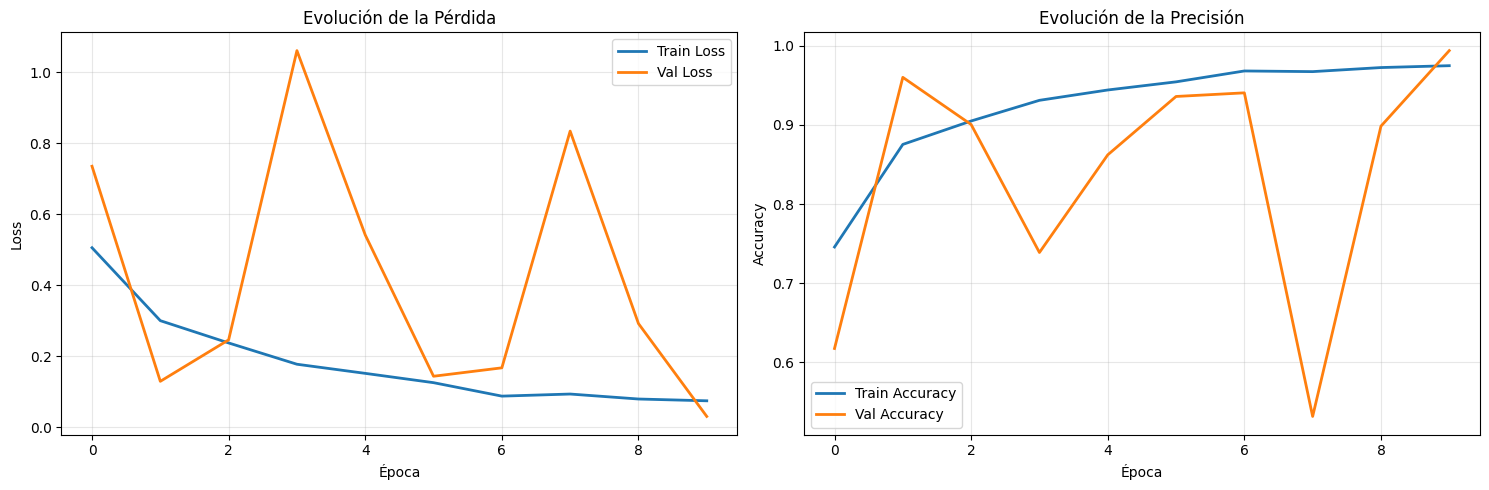

In [104]:
# Graficar curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Evolución de la Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Evolución de la Precisión')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [105]:
# Cargar mejor modelo para evaluación
model.load_state_dict(torch.load('best_cnn_model.pth'))
print("Mejor modelo cargado para evaluación")

Mejor modelo cargado para evaluación


In [106]:
# Función para obtener predicciones
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc='Prediciendo'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [107]:
# Obtener predicciones para conjunto de validación
val_preds, val_labels, val_probs = get_predictions(model, val_loader, DEVICE)
val_accuracy = accuracy_score(val_labels, val_preds)

print("\n" + "="*50)
print("RESULTADOS EN CONJUNTO DE VALIDACIÓN")
print("="*50)
print(f"\nAccuracy: {val_accuracy:.4f}\n")
print("\nReporte de Clasificación:")
print(classification_report(val_labels, val_preds, target_names=CLASSES))

Prediciendo: 100%|██████████| 150/150 [00:32<00:00,  4.59it/s]


RESULTADOS EN CONJUNTO DE VALIDACIÓN

Accuracy: 0.9938


Reporte de Clasificación:
               precision    recall  f1-score   support

kidney_normal       1.00      0.99      0.99      1200
 kidney_tumor       0.99      1.00      0.99      1200

     accuracy                           0.99      2400
    macro avg       0.99      0.99      0.99      2400
 weighted avg       0.99      0.99      0.99      2400



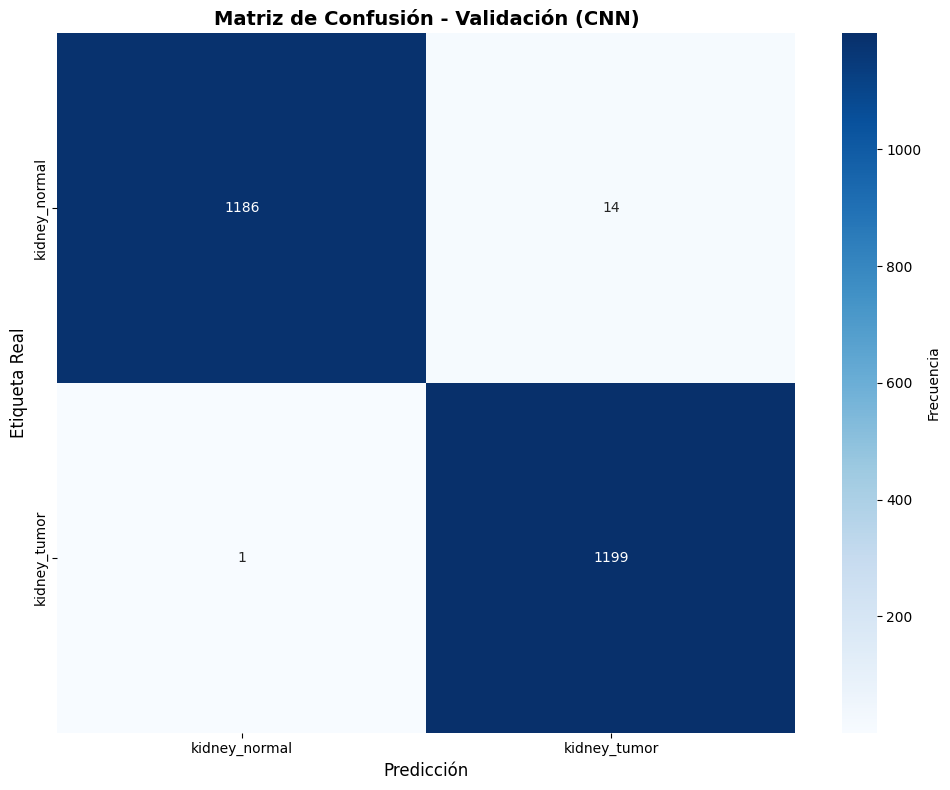

In [108]:
# Matriz de confusión para validación
cm_val = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Validación (CNN)', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

In [109]:
# Obtener predicciones para conjunto de prueba
test_preds, test_labels, test_probs = get_predictions(model, test_loader, DEVICE)
test_accuracy = accuracy_score(test_labels, test_preds)

print("\n" + "="*50)
print("RESULTADOS EN CONJUNTO DE PRUEBA")
print("="*50)
print(f"\nAccuracy: {test_accuracy:.4f}\n")
print("\nReporte de Clasificación:")
print(classification_report(test_labels, test_preds, target_names=CLASSES))

Prediciendo: 100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


RESULTADOS EN CONJUNTO DE PRUEBA

Accuracy: 0.9967


Reporte de Clasificación:
               precision    recall  f1-score   support

kidney_normal       1.00      0.99      1.00      1200
 kidney_tumor       0.99      1.00      1.00      1200

     accuracy                           1.00      2400
    macro avg       1.00      1.00      1.00      2400
 weighted avg       1.00      1.00      1.00      2400



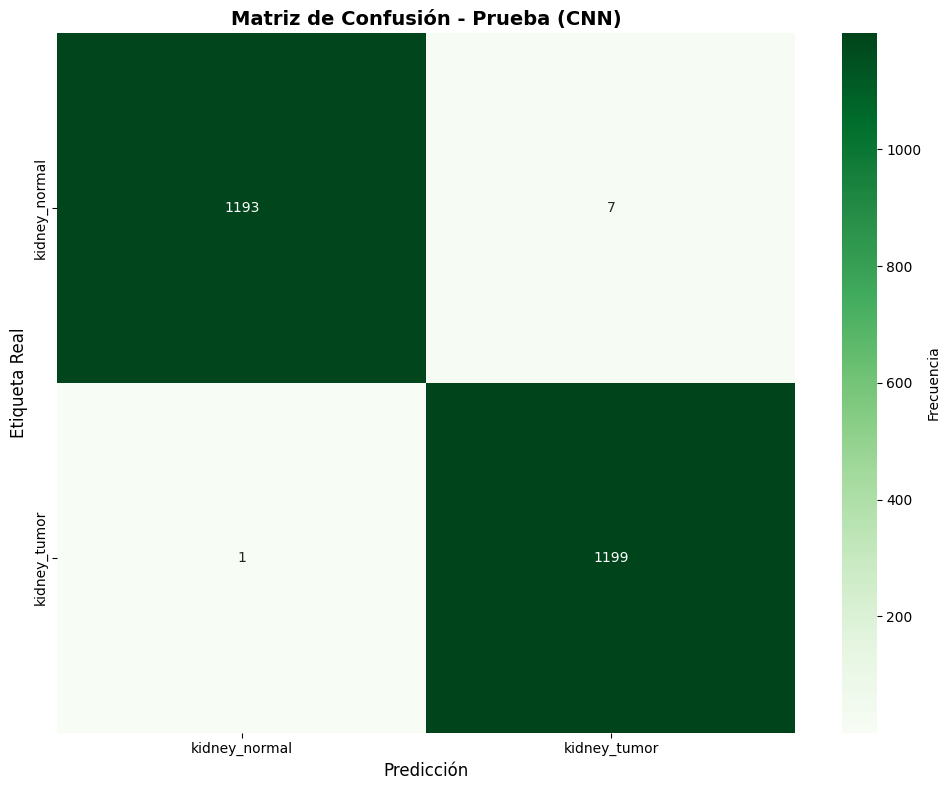

In [110]:
# Matriz de confusión para prueba
cm_test = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Frecuencia'})
plt.title('Matriz de Confusión - Prueba (CNN)', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

Prediciendo: 100%|██████████| 450/450 [02:58<00:00,  2.52it/s]


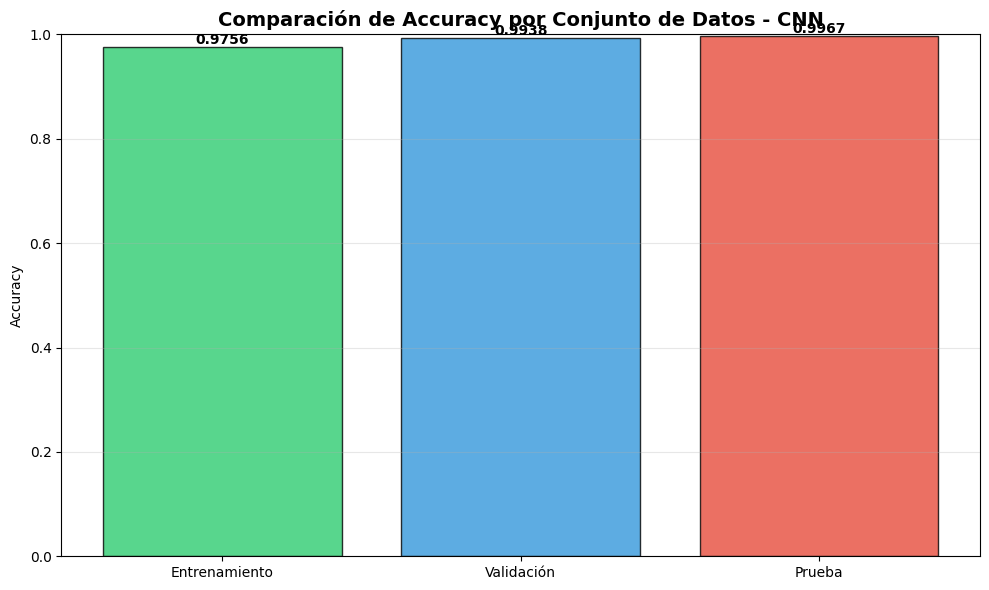


Accuracy Entrenamiento: 0.9756
Accuracy Validación: 0.9938
Accuracy Prueba: 0.9967


In [111]:
# Comparar accuracy entre conjuntos
train_preds, train_labels, _ = get_predictions(model, train_loader, DEVICE)
train_accuracy = accuracy_score(train_labels, train_preds)

plt.figure(figsize=(10, 6))
accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels_plot = ['Entrenamiento', 'Validación', 'Prueba']
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = plt.bar(labels_plot, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy por Conjunto de Datos - CNN', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAccuracy Entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy Validación: {val_accuracy:.4f}")
print(f"Accuracy Prueba: {test_accuracy:.4f}")

In [112]:
# Guardar modelo final
torch.save({
    'epoch': len(history['train_loss']),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc': train_accuracy,
    'val_acc': val_accuracy,
    'test_acc': test_accuracy,
    'history': history
}, 'models/cnn_model_final.pth')

print("Modelo final guardado en: cnn_model_final.pth")

Modelo final guardado en: cnn_model_final.pth


In [7]:
# Función para predecir una nueva imagen
def predecir_imagen(ruta_imagen, modelo, device, classes, img_size=(512, 512)):
    """
    Predice la clase de una imagen usando el modelo CNN entrenado.
    
    Args:
        ruta_imagen: Ruta de la imagen a predecir
        modelo: Modelo CNN entrenado
        device: Dispositivo (CPU o GPU)
        classes: Lista de nombres de clases
        img_size: Tamaño al que redimensionar la imagen
    
    Returns:
        Índice de la clase predicha
    """
    # Transformación para la imagen
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Cargar y preprocesar imagen
    img = Image.open(ruta_imagen).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Realizar predicción
    modelo.eval()
    with torch.no_grad():
        output = modelo(img_tensor)
        probabilidades = torch.softmax(output, dim=1)[0]
        prediccion = torch.argmax(probabilidades).item()
    
    # Convertir a numpy
    probabilidades = probabilidades.cpu().numpy()
    
    # Mostrar resultados
    print(f"Clase predicha: {classes[prediccion]}")
    print("\nProbabilidades por clase:")
    for i, prob in enumerate(probabilidades):
        print(f"  {classes[i]}: {prob:.4f}")
    
    # Mostrar imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(Image.open(ruta_imagen))
    plt.title(f"Predicción: {classes[prediccion]} ({probabilidades[prediccion]:.2%})", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return prediccion

# Ejemplo de uso:
# predecir_imagen('ruta/a/tu/imagen.jpg', model, DEVICE, CLASSES, IMG_SIZE)

<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:34: SyntaxWarning: invalid escape sequence '\c'
C:\Users\rrobe\AppData\Local\Temp\ipykernel_23052\1159822903.py:34: SyntaxWarning: invalid escape sequence '\c'
  modelo_cargado = cargar_modelo('models\cnn_model_final.pth', 'cuda')


Modelo cargado desde: models\cnn_model_final.pth
Train Accuracy: 0.9755555555555555
Val Accuracy: 0.99375
Test Accuracy: 0.9966666666666667
Clase predicha: kidney_tumor

Probabilidades por clase:
  kidney_normal: 0.0001
  kidney_tumor: 0.9999


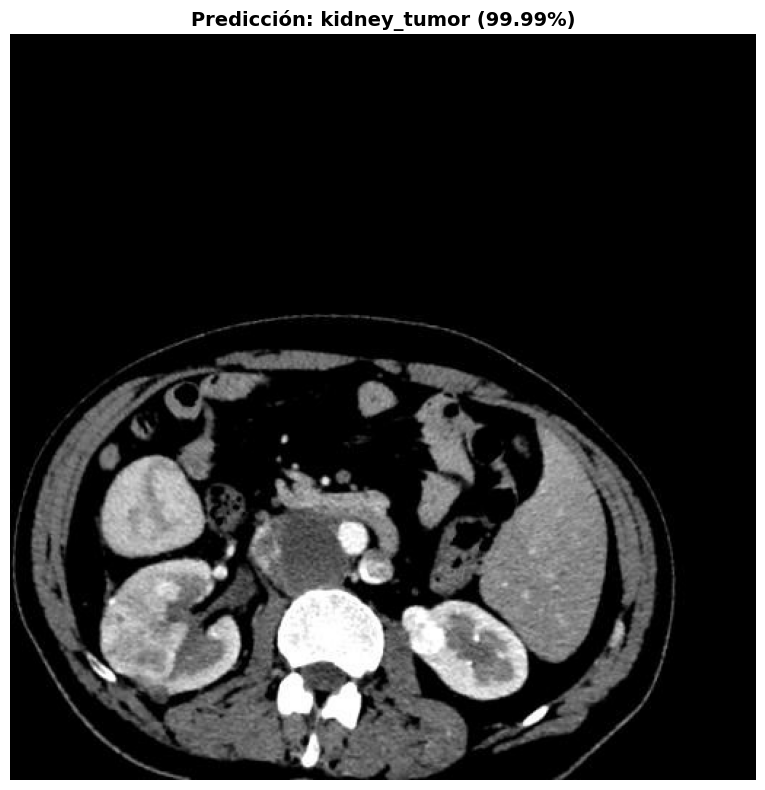

1

In [8]:
# Función para cargar un modelo previamente guardado
def cargar_modelo(model_path, device, num_classes=2):
    """
    Carga un modelo CNN desde un archivo.
    
    Args:
        model_path: Ruta del archivo del modelo
        device: Dispositivo (CPU o GPU)
        num_classes: Número de clases
    
    Returns:
        Modelo CNN cargado
    """
    # Crear instancia del modelo
    modelo = CNN(num_classes=num_classes).to(device)
    
    # Cargar pesos
    checkpoint = torch.load(model_path, map_location=device)
    
    if 'model_state_dict' in checkpoint:
        modelo.load_state_dict(checkpoint['model_state_dict'])
        print(f"Modelo cargado desde: {model_path}")
        print(f"Train Accuracy: {checkpoint.get('train_acc', 'N/A')}")
        print(f"Val Accuracy: {checkpoint.get('val_acc', 'N/A')}")
        print(f"Test Accuracy: {checkpoint.get('test_acc', 'N/A')}")
    else:
        modelo.load_state_dict(checkpoint)
        print(f"Modelo cargado desde: {model_path}")
    
    modelo.eval()
    return modelo

# Ejemplo de uso:
modelo_cargado = cargar_modelo('models\cnn_model_final.pth', 'cuda')
predecir_imagen('Dataset/kidney_tumor/kidney_tumor_0003.jpg', modelo_cargado, DEVICE, CLASSES, IMG_SIZE)

Generando visualizaciones de Grad-CAM...
Esto muestra qué regiones de las imágenes el modelo está utilizando para hacer sus predicciones.



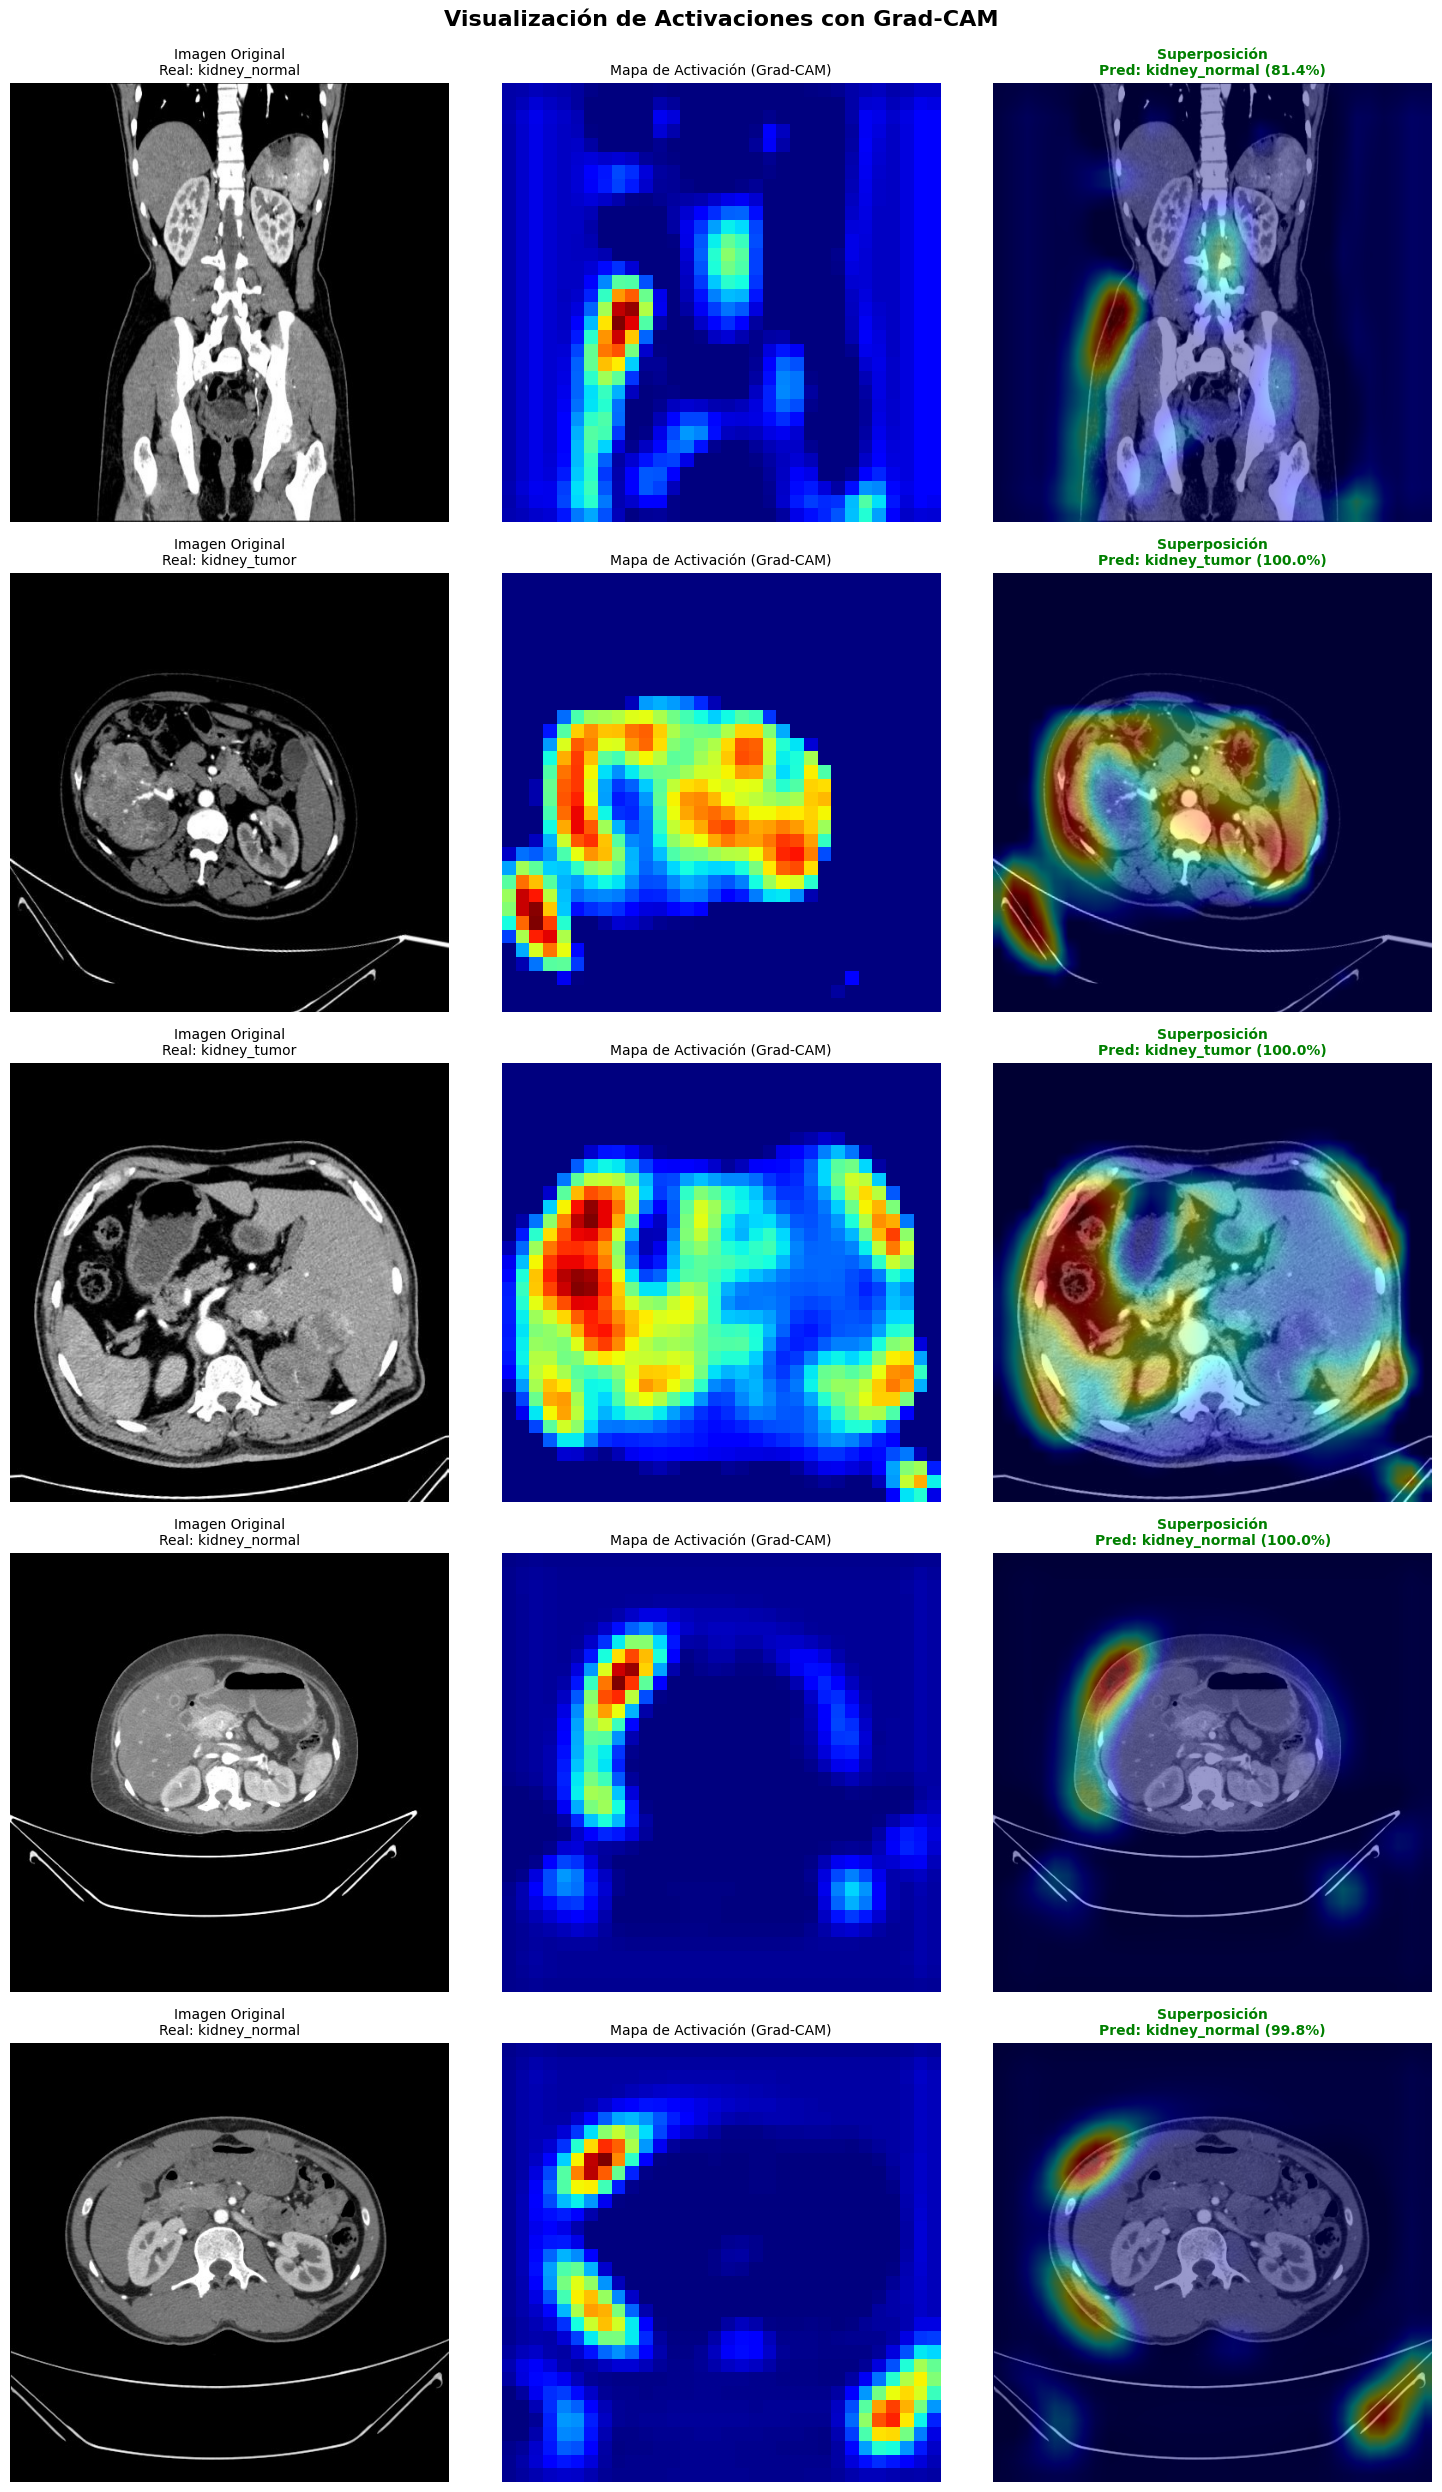

In [115]:
# Implementación de Grad-CAM para visualizar activaciones
import cv2

class GradCAM:
    """Implementa Grad-CAM para visualización de mapas de activación"""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Registrar hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        """
        Genera el mapa de activación de clase (CAM)
        
        Args:
            input_image: Tensor de entrada (1, C, H, W)
            target_class: Clase objetivo (si es None, usa la clase predicha)
        
        Returns:
            cam: Mapa de calor normalizado
        """
        # Forward pass
        model_output = self.model(input_image)
        
        if target_class is None:
            target_class = model_output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        class_score = model_output[:, target_class]
        class_score.backward()
        
        # Calcular pesos
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Ponderar activaciones
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        
        # Promedio de canales
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        
        # ReLU y normalización
        heatmap = torch.maximum(heatmap, torch.tensor(0.0))
        heatmap /= torch.max(heatmap) if torch.max(heatmap) > 0 else torch.tensor(1.0)
        
        return heatmap.cpu().numpy()

def apply_colormap_on_image(org_img, activation_map, alpha=0.5):
    """
    Superpone el mapa de activación sobre la imagen original
    
    Args:
        org_img: Imagen original (PIL o numpy array)
        activation_map: Mapa de activación
        alpha: Transparencia del mapa de calor
    
    Returns:
        Imagen con el mapa de calor superpuesto
    """
    # Convertir PIL a numpy si es necesario
    if isinstance(org_img, Image.Image):
        org_img = np.array(org_img)
    
    # Redimensionar mapa de activación al tamaño de la imagen
    heatmap = cv2.resize(activation_map, (org_img.shape[1], org_img.shape[0]))
    
    # Aplicar colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superponer
    superimposed_img = heatmap * alpha + org_img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)
    
    return superimposed_img

def visualizar_activaciones_gradcam(modelo, dataset, device, classes, num_imagenes=5):
    """
    Visualiza imágenes con sus mapas de activación usando Grad-CAM
    
    Args:
        modelo: Modelo CNN entrenado
        dataset: Dataset de PyTorch
        device: Dispositivo (CPU o GPU)
        classes: Lista de nombres de clases
        num_imagenes: Número de imágenes a visualizar
    """
    modelo.eval()
    
    # Usar la última capa convolucional del último bloque (conv5)
    grad_cam = GradCAM(modelo, modelo.conv5[-3])  # Segunda Conv2d en conv5
    
    # Seleccionar imágenes aleatorias
    indices = np.random.choice(len(dataset), num_imagenes, replace=False)
    
    fig, axes = plt.subplots(num_imagenes, 3, figsize=(15, 5*num_imagenes))
    
    for i, idx in enumerate(indices):
        img_path = dataset.image_paths[idx]
        true_label = dataset.labels[idx]
        
        # Cargar imagen original
        img_original = Image.open(img_path).convert('RGB')
        img_original_resized = img_original.resize(IMG_SIZE)
        
        # Preparar tensor para el modelo
        img_tensor, _ = dataset[idx]
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        # Realizar predicción
        with torch.no_grad():
            output = modelo(img_tensor)
            prob = torch.softmax(output, dim=1)[0]
            pred_label = torch.argmax(prob).item()
            confidence = prob[pred_label].item()
        
        # Generar Grad-CAM
        cam = grad_cam.generate_cam(img_tensor, target_class=pred_label)
        
        # Aplicar mapa de calor sobre la imagen
        img_with_heatmap = apply_colormap_on_image(img_original_resized, cam, alpha=0.4)
        
        # Graficar
        # Imagen original
        axes[i, 0].imshow(img_original_resized)
        axes[i, 0].set_title(f'Imagen Original\nReal: {classes[true_label]}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Mapa de calor
        axes[i, 1].imshow(cam, cmap='jet')
        axes[i, 1].set_title(f'Mapa de Activación (Grad-CAM)', fontsize=10)
        axes[i, 1].axis('off')
        
        # Superposición
        color = 'green' if pred_label == true_label else 'red'
        axes[i, 2].imshow(img_with_heatmap)
        axes[i, 2].set_title(
            f'Superposición\nPred: {classes[pred_label]} ({confidence:.1%})',
            fontsize=10,
            color=color,
            weight='bold'
        )
        axes[i, 2].axis('off')
    
    plt.suptitle('Visualización de Activaciones con Grad-CAM', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Visualizar activaciones
print("Generando visualizaciones de Grad-CAM...")
print("Esto muestra qué regiones de las imágenes el modelo está utilizando para hacer sus predicciones.\n")
visualizar_activaciones_gradcam(model, test_dataset, DEVICE, CLASSES, num_imagenes=5)